In [448]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
import pandas as pd
import sklearn.linear_model
import sklearn.metrics

In [3]:
dataset = pd.read_pickle('deception_df.pkl')

In [4]:
print(dataset.head())

                                            messages  sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...           True   
1  You've whet my appetite, Italy. What's the sug...           True   
2                                                  👍           True   
3  It seems like there are a lot of ways that cou...           True   
4  Yeah, I can’t say I’ve tried it and it works, ...           True   

  receiver_labels speakers receivers  absolute_message_index  \
0            True    italy   germany                      74   
1            True  germany     italy                      76   
2            True    italy   germany                      86   
3            True  germany     italy                      87   
4    NOANNOTATION    italy   germany                      89   

   relative_message_index seasons years game_score game_score_delta  \
0                       0  Spring  1901          3                0   
1                       1  Spring  1901       

As a first step, let us do something about the missing values in the `receiver_labels` column, denoted by NOANNOTATION. Since less than 10% of data is missing, we just drop those rows.

In [5]:
dataset.loc[dataset['receiver_labels'] == 'NOANNOTATION', 'receiver_labels'] = None
dataset.dropna(axis=0, subset=['receiver_labels'], inplace=True)
dataset['receiver_labels'] = dataset['receiver_labels'].astype(bool)

#### Confusion matrix

For future reference, we will compute a confusion matrix of lies and perceived lies right now.

In [863]:
# Truth = negative, lie = positive
tp_mask = ~dataset['sender_labels'] & ~dataset['receiver_labels']
fp_mask = dataset['sender_labels'] & ~dataset['receiver_labels']
fn_mask = ~dataset['sender_labels'] & dataset['receiver_labels']
tn_mask = dataset['sender_labels'] & dataset['receiver_labels']
tp = sum(tp_mask) # Lies perceived as lies
fp = sum(fp_mask) # Truths perceived as lies
tn = sum(tn_mask) # Truths perceived as truths
fn = sum(fn_mask) # Lies perceived as truths

print("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

TP: 111, FP: 667, TN: 14314, FN: 691


#### The motivation for matching

We wish to answer the three following questions:

1. Are the linguistic features (e.g. higher politeness) found in messages leading up to a betrayal similar to the features found in lies?
2. Are the linguistic features of lies similar to the features of perceived lies?
3. How do the linguistic features of truths perceived as truth, truths perceived as lies, undetected lies, and detected lies differ?

All three of these questions involve a population of messages. In each question, we will be comparing a set of features of these messages across several groups: 2 groups for questions 1 and 2, 4 groups for question 3. This observation allows us in what follows to identify a common pitfall as well as a common solution to it for all three questions.

Our first instinct might be to indiscriminately compare the groups of messages defined in each question. This would pose a problem to the validity of our answers, as any correlations we might infer would be in danger of being _spurious_ correlations.
Take for instance the second question. Even though a message might be a lie and a perceived lie at the same time, we consider the groups of lies and perceived lies to be mutually exclusive: it is as if we had two messages with identical content, but where one is in the group of lies and the other in the group of perceived lies. In conventional terms, we might arbitrarily designate one of these groups as the control group and the other as the treatment group.
Let's accept as a premise that how well the game is going for the sender of a message influences both whether the message is a lie (or a perceived lie) and the politeness of the message: if the game is going well for the sender, he is less likely to lie (no need) and messages are more polite (less stress), whereas if the game is going badly for the sender, he is more likely to lie and messages are less polite. What we are going to see in the data is that messages which are lies will be less polite: this would be a spurious correlation, as we know from the original paper that lying is in general associated with more politeness, not less (the authors hypothesize lying causes the sender to "cover up his tracks" by being more polite)! In fact, the increased politeness would be due to the state of the game, not which group the message belongs to.

A causal map of this situation might look like this, where G denotes how well the game is going, L whether the message is a lie or not and P the politeness of the message:
```
----(G)----
|         |
|         |
v         v
(L)----->(P)
```

It is easy to see from this diagram that how well the game is going is a confounder.

Both the dataset of the initial paper, "Linguistic Harbingers of Betrayal", as well as this one, coming from the paper "It Takes Two to Lie: One to Lie, and One to Listen" are what we could call "found data". The questions we are asking would hardly lend themselves to an analysis conducted in a so-called "natural experiment" paradigm, as we have just shown. Instead, we are conducting an observational study which forces us to account for confounders.

To remediate the problem of confounding variables, we would ideally like to match the examined groups on their confounding variables, so that any effect would be due to the group membership. Unfortunately, finding a close match can prove hard in practice. To circumvent this, we can instead resort to propensity score matching (PSM). The propensity indicates the probability of an individual sample to be in the treatment group, given its covariates (although we only consider those covariates that might be confounders, in this case). PSM means matching every observation in the treatment group to an observation in the control group with a similar propensity, which more or less nullifies the causal relation between the confounder and the group membership, thus removing it as a confounder. The general process we will use for PSM is as follows:

1. Pick the dependent variable which defines group membership.
2. Pick the observed covariates which we believe might be confounders.
3. Fit a logistic regression with the confounders as inputs and the dependent variable as output to model the propensity score.
4. Compute the propensity score for all messages.
5. Check that the covariates (confounders) are balanced (i.e. have a similar distribution) across the groups within strata (which we will define here as propensity score bins).
5. Perform the matching using caliper matching.
6. Check that the covariates are balanced across the groups.

Caliper matching is a greedy form of bipartite matching (one control observation can be associated to only one treatment observation), where a match is accepted if the difference in propensity scores is below a certain threshold. Also note that we specify logistic regression in the above algorithm, but only because it tends to perform well: we could otherwise use another ML algorithm to compute the propensity score. It is important to note that PSM only accounts for observable confounder, **not** for latent (i.e. unobserved) variables. The general process we identified allows us to write a unique method for PSM.

#### Advanced matching

Question 2 offers a typical setup for matching. However, question 1 and 3 both pose certain difficulties when it comes to matching.

In question 3, we have not two but four groups! Our process will encur the following modifications. In step 1, we need to create a dependent variable of our own, which will take 4 values instead of 2. In step 3, we need to fit a _multinomial_ logistic regression instead of a simple logistic regression: it will output a probability (i.e. propensity score) for each of the four class labels. In step 6, the caliper will be applied to all four propensities, and we will be moving from a *bipartite* matching problem to a *multipartite* matching problem. Finally, in step 7, we will check the covariate balance across 4 groups instead of two.

In [859]:
def compute_propensity_scores(dataset, group_masks, confounder_cols):
    """Compute the propensity scores of a sample.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    group_masks : list of pd.Series
        A list of boolean masks identifying members of each group.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
        
    Returns
    -------
    group_data : pd.DataFrame
        The treatment and control groups.
    """
    groups = [dataset[group_mask].copy() for group_mask in group_masks]
    for i, group in enumerate(groups):
        group['treatment'] = i
    group_data = pd.concat(groups)
    X_train, y_train = group_data[confounder_cols], group_data['treatment']
    
    propensity_model = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
    group_data['propensity_scores'] = list(propensity_model.predict_proba(X_train))
    
    return group_data

def psm(dataset, group_masks, confounder_cols, max_caliper=0.2):
    """Perform propensity score caliper matching between the treatment and control groups.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    group_masks : list of pd.Series
        A list of boolean masks identifying members of each group.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
    max_caliper : float
        The maximum allowed difference between the propensity scores of the observations.
        
    Returns
    -------
    matches : list of tuples of ints
        A list of ordered pairs of index values for respectively the treatment and control groups.
    """
    
    group_data = compute_propensity_scores(dataset, group_masks, confounder_cols)
    
    matches = []
    
    groups = [group_data[group_data['treatment'] == i] for i in group_data['treatment'].unique()]
    groups = sorted(groups, key=len)
    smallest_group, search_groups = groups[0], groups[1:]
    smallest_indices, search_indices = list(smallest_group.index), list(map(lambda group: list(group.index), search_groups))
    
    def caliper_valid(propensities):
        pair_propensity_differences = np.vstack(list(map(lambda pair: abs(pair[0] - pair[1]), itertools.combinations(propensities[:], 2))))
        return (pair_propensity_differences < max_caliper).all()
    
    test_p = np.array([[1, 2, 3], [6, 5, 4], [7, 8, 9]])
    caliper_valid(test_p)
    
    while len(smallest_indices) > 0:
        possible_match_index_tuples = itertools.product([smallest_indices.pop()], *search_indices)
        match = next((possible_match for possible_match in possible_match_index_tuples if caliper_valid(np.vstack(list(map(lambda match, group: group.loc[match, 'propensity_scores'], possible_match, groups))))), None)
        if match:
            matches.append(match)
            for group_idx, search_index in enumerate(match[1:]):
                search_indices[group_idx].remove(search_index)
            
    print("Matched {} treatment observations out of max {} (success rate {:.2%}).".format(len(matches), len(smallest_group), len(matches) / len(smallest_group)))
            
    return matches

For all three questions, we will examine the same linguistic features, namely `politeness`, `negative_sentiment`, `neutral_sentiment` and `positive_sentiment`: we consider these to be our effect variables. The examined groups vary for each questions, but we identify a common set of (potential) confounders: `game_score`, `game_score_delta`, `years`. Every covariate is a potential confounder (in practice, not all are, but there is no sure way of knowing), but a balance must be struck between the chosen confounders, the caliper and the matching success rate (proportion of matched treatment observations).

In [860]:
effect_cols = ['politeness', 'negative_sentiment', 'neutral_sentiment', 'positive_sentiment']
confounder_cols = ['game_score', 'game_score_delta', 'years']

#### 2. Are the linguistic features of lies similar to the features of perceived lies?

A lie which is perceived as a lie is in both the control and treatment group. In fact, if all lies were perceived as lies, no matching would be needed, and lies and perceived lies would have identical features! Of course, in reality, some players are overly naive and some overly suspicious, which prevents this from being the case. In fact, lies correctly perceived as lies are a minority, numbering only 111, while truths perceived as lies and lies perceived as truths together number 1358. While the best matching for these 111 messages is with themselves, the 1358 messages must be matched among themselves, warranting the use of PSM.

We choose the dependent variable to be whether a message is a lie or a perceived lie. The treatment group is chosen to be the lies and the control group the perceived lies.

In [861]:
treatment_mask_q2 = ~dataset['sender_labels']
control_mask_q2 = ~dataset['receiver_labels']

matches_q2 = psm(dataset, [treatment_mask_q2, control_mask_q2], confounder_cols, max_caliper=0.001)

selected_lie_indices = [m for (m, n) in matches_q2]
selected_lies = dataset.loc[selected_lie_indices]
selected_perceived_lie_indices = [n for (m, n) in matches_q2]
selected_perceived_lies = dataset.loc[selected_perceived_lie_indices]

Matched 602 treatment observations out of max 778 (success rate 77.38%).


Balance test for confounder game_score


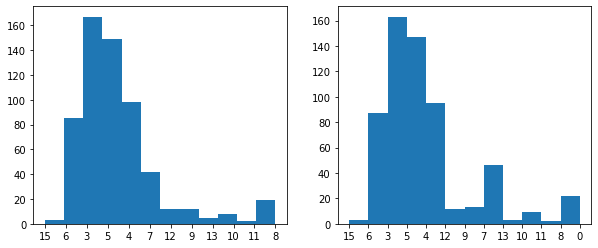

Balance test for confounder game_score_delta


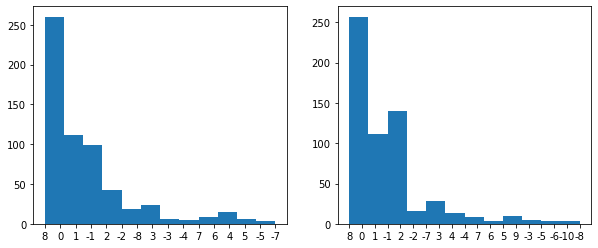

Balance test for confounder years


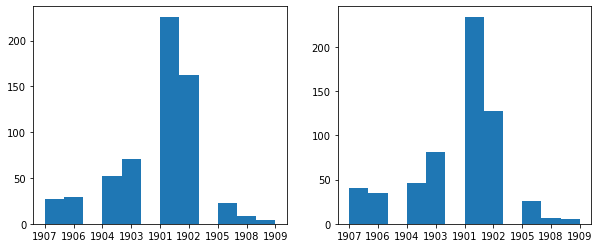

In [862]:
def check_balance(dataset, matches, confounder_cols):
    """Visualize the confounder distributions across groups to check balance.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    matches : list of (int, int)
        A list of ordered pairs of index values for respectively the treatment and control groups.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
    """
    groups = []
    for group_idx in range(len(matches[0])):
        group_indices = [match[group_idx] for match in matches]
        group = dataset.loc[group_indices]
        groups.append(group)
    
    for confounder_col in confounder_cols:
        print("Balance test for confounder {}".format(confounder_col))
        
        n_rows = math.ceil(len(groups) / 4)
        n_cols = len(groups) if n_rows == 1 else 4 
        fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False, figsize=(10, 4))
        for i, group in enumerate(groups):
            row_idx = i // n_cols
            col_idx = i % n_cols
            ax[row_idx, col_idx].hist(list(group[confounder_col]), bins=12)
        
        plt.show()
        
check_balance(dataset, matches_q2, confounder_cols)

#### 3. How do the linguistic features of truths perceived as truth, truths perceived as lies, undetected lies, and detected lies differ?

In [873]:
matches_q3 = psm(dataset, [tn_mask, fp_mask, fn_mask, tp_mask], confounder_cols, max_caliper=0.186)

Matched 111 treatment observations out of max 111 (success rate 100.00%).


Balance test for confounder game_score


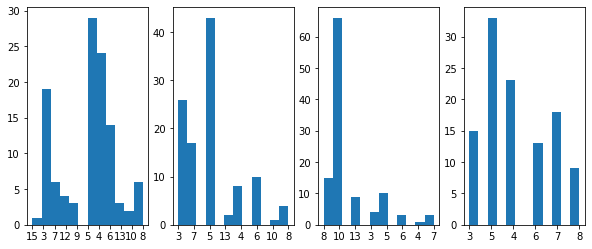

Balance test for confounder game_score_delta


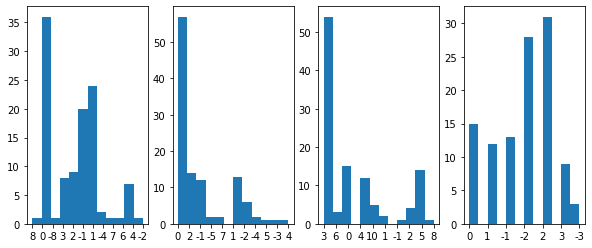

Balance test for confounder years


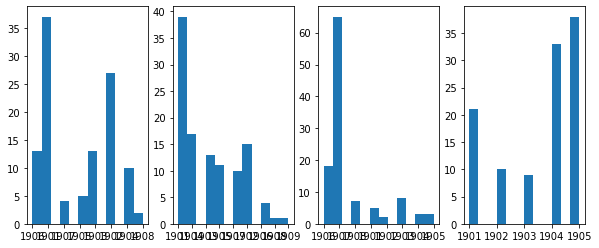

In [865]:
check_balance(dataset, matches_q3, confounder_cols)